# 1 - Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools
import datetime
from state_prep_opt import *

/home/shanjha/.conda/envs/bosonic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2 - Settings

In [3]:
settings = {
    "measure": None,
    "blocks": 8,
    "batch_size": 1000,
    "epochs": 2000,
    "learning_rate": 5e-3,
    "N": 75,
    "state": {
        "mode": "gkp",
        "logical_state": "-x",
        "delta": 0.37
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 35,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": True
}

if settings["state"]["mode"]=="fock":
    if settings["state"]["logical_state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["logical_state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["logical_state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["logical_state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["logical_state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["logical_state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()
elif settings["state"]["mode"] == "gkp":
    delta = settings["state"]["delta"]
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": settings["N"]})
    squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))
    settings["state"]["squeezing_level"] = squeezing_level
    target_state_cavity = gkp_qubit.basis[settings["state"]["logical_state"]]

settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

# 4 - Batch Gradient Descent

In [4]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [5]:
# Functions


# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

32.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
741 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
207 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
history = optimize(random_initial_params, settings)

Running for 2,000 iterations: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [28:29<00:00,  1.17it/s]


In [7]:
fids_history = history["fids"]
metric_batch_history = history["metric_batch"]
params_history = history["params"]
metric_history = history["metric"]

In [8]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [9]:
best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

In [10]:
if settings["minimize_metric"] == False:
    best_params = params_history[best_fids_epoch_indx, best_fids_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]
np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

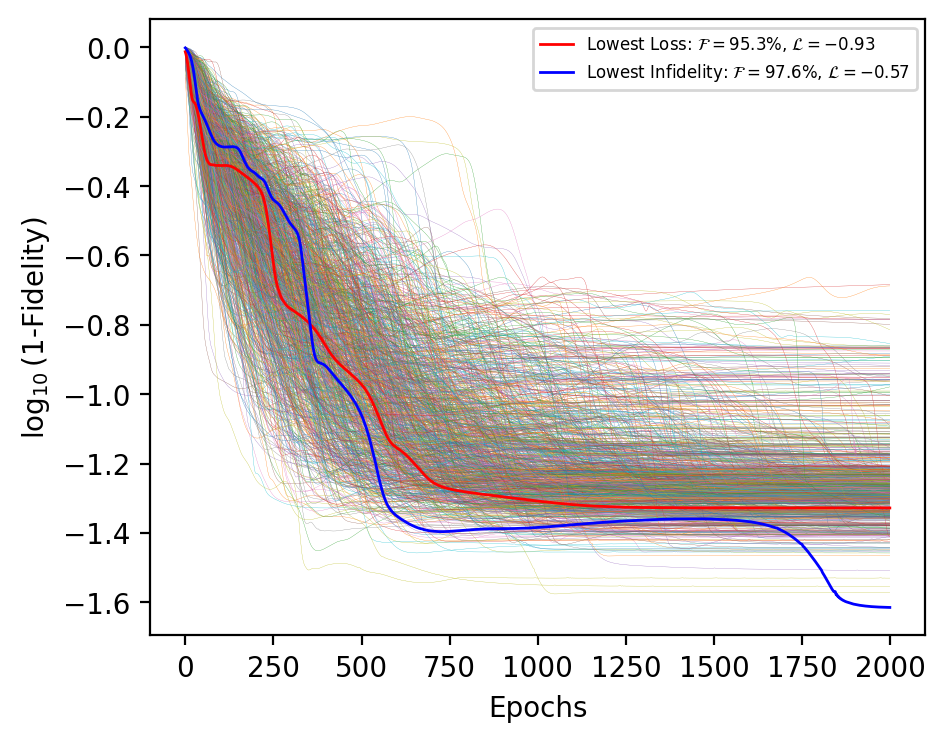

In [11]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x147fa08de8c0>)

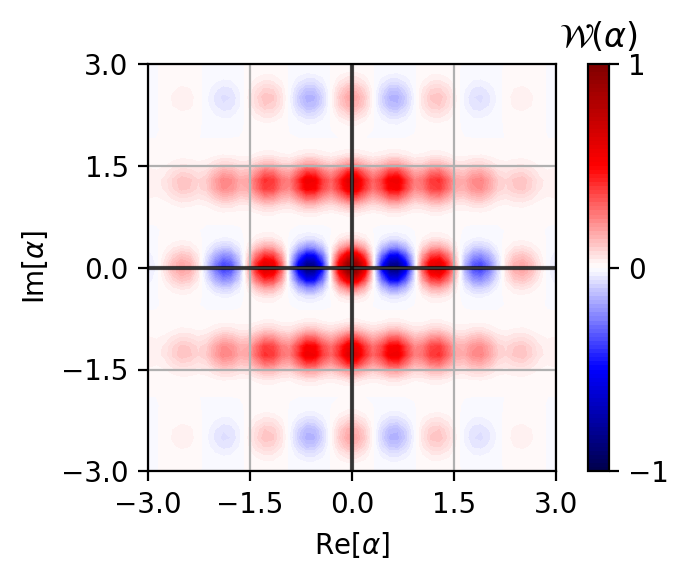

In [12]:
pts = jnp.linspace(-3, 3, 50)
jqt.plot_wigner(target_state_cavity, pts)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x147f37772e90>)

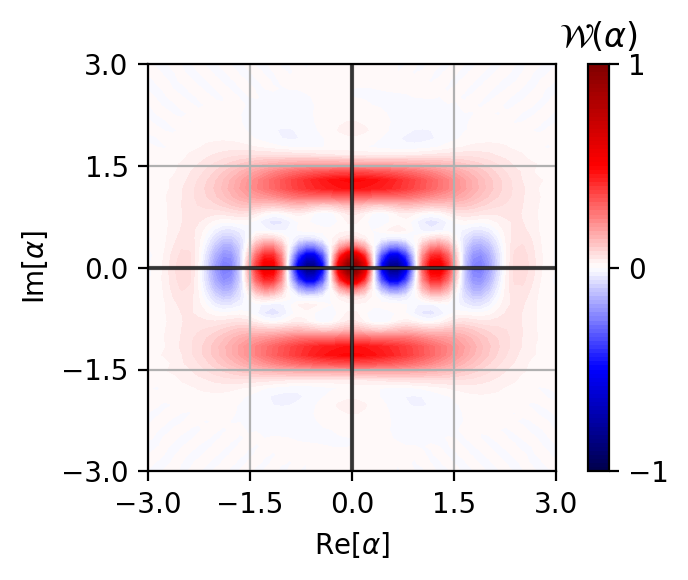

In [13]:
pts = jnp.linspace(-3, 3, 50)
prepared_state = run_circuit(params_history[best_metric_epoch_indx, best_metric_batch_indx], settings["N"])
jqt.plot_wigner(prepared_state, pts)

In [14]:
# data=np.load(r"./data/20251014_h16m53s23_fock_state_prep_plusx.npz", allow_pickle=True)
# optimal_instructions = data["best_params"]

# best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

# prepared_state = run_circuit(best_params, 100)

Best parameters: 
 [[ 2.356350e-01  5.139360e-01  6.293990e-01  5.984640e-01  8.013260e-01
   6.058590e-01  2.536570e-01  1.860740e-01]
 [ 2.497150e-01  3.778470e-01  2.226120e-01  7.887800e-02  8.983500e-02
   9.825290e-01  5.218580e-01  2.494900e-01]
 [-1.016330e+00  8.417790e-01 -6.239880e-01  1.741100e-02 -7.552850e-01
  -1.102244e+00 -2.649700e-02 -1.440000e-04]
 [ 7.157200e-02 -3.347900e-02 -5.627710e-01 -1.377674e+00 -1.327370e-01
   2.211130e-01 -3.107780e-01 -3.600000e-04]]


KeyError: 'state'

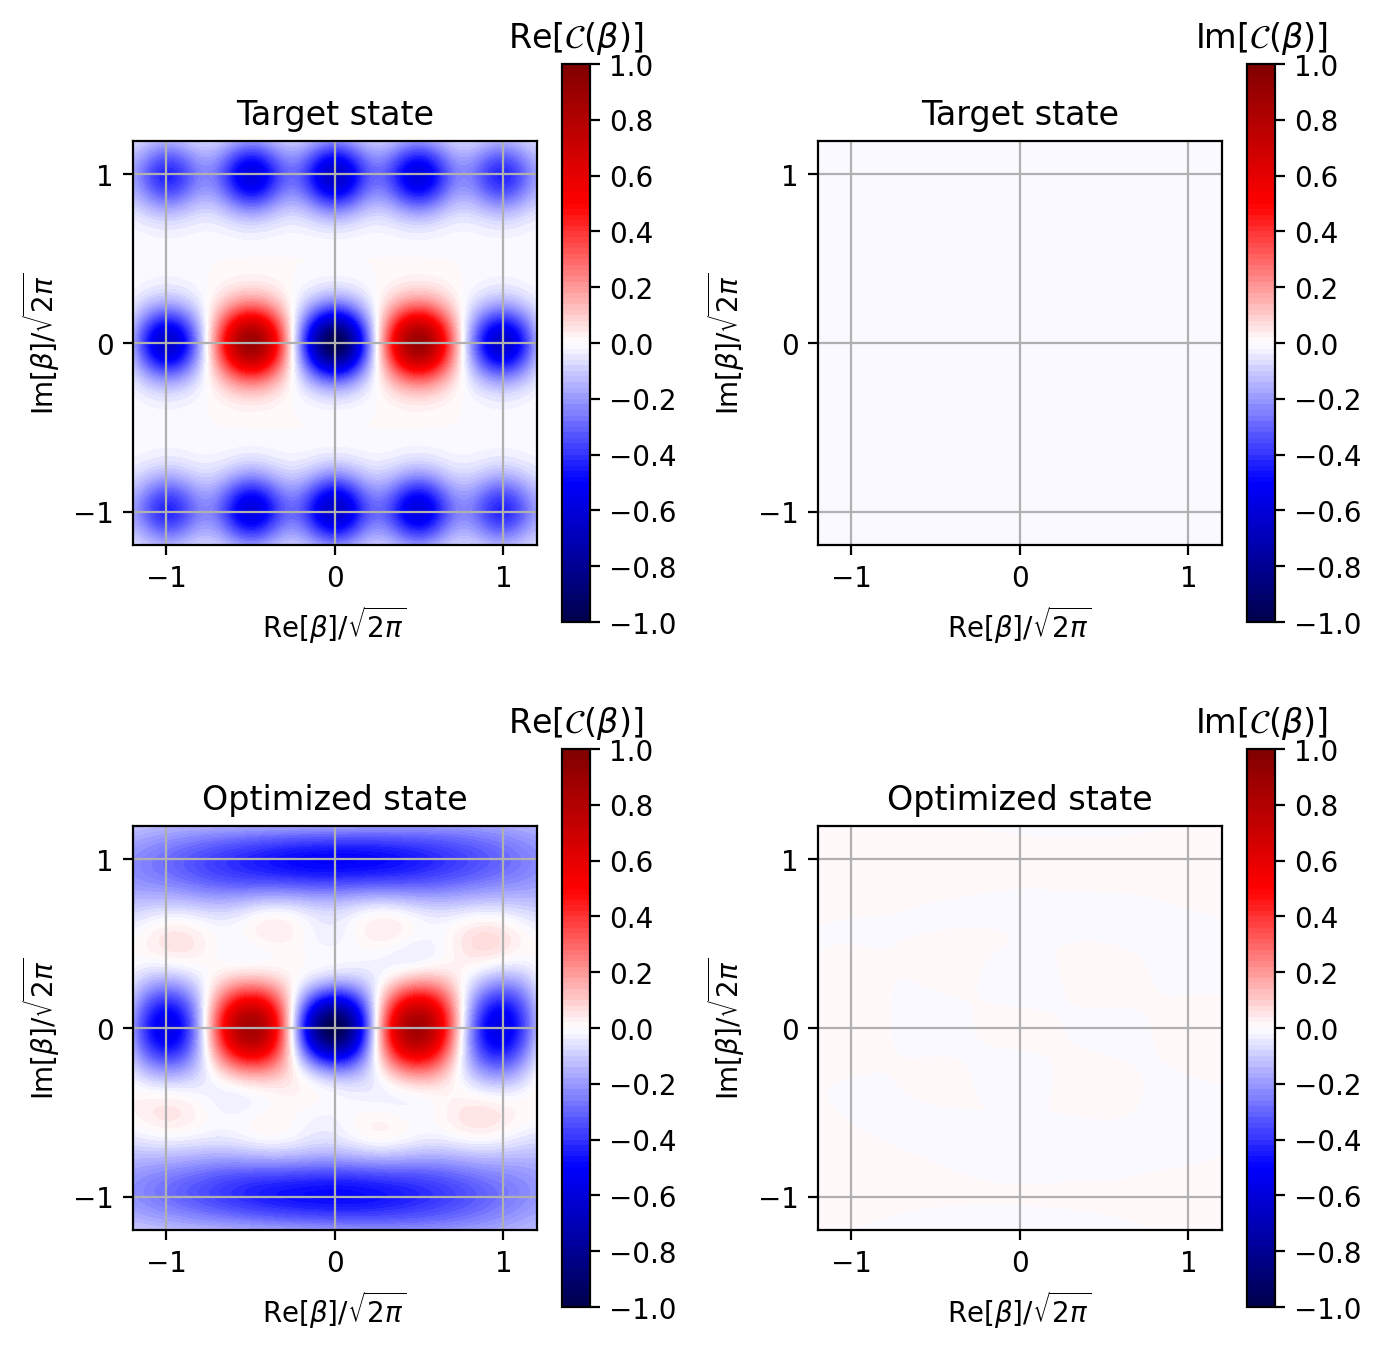

In [15]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(7,7))
axs = axs.flatten()
print("Best parameters: \n", best_params)
N_large = 75
if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()
elif settings["state"]["mode"] == "gkp":
    delta = settings["state"]["delta"]
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": settings["N"]})
    squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))
    settings["state"]["squeezing_level"] = squeezing_level
    target_state_cavity = gkp_qubit.basis[settings["state"]["logical_state"]]

target_state_larger = jqt.basis(2,0) ^ target_state_cavity

prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)



betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")



fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['state']}\\rangle,$ $\\mathcal{{F}}={fid:.3f}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)

In [16]:
settings = {
    "measure": None,
    "blocks": 4,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 75,
    "state": {
        "mode": "fock",
        "state": "+y"
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 35,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": True
}

if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()


settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

# 4 - Batch Gradient Descent

In [17]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [18]:
# Functions


# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

199 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
56.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
187 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
52.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
history = optimize(random_initial_params, settings)

Running for 1,000 iterations: 100%|█████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.49it/s]


In [20]:
fids_history = history["fids"]
metric_batch_history = history["metric_batch"]
params_history = history["params"]
metric_history = history["metric"]

In [21]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [22]:
best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

In [23]:
if settings["minimize_metric"] == False:
    best_params = params_history[best_fids_epoch_indx, best_fids_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]
np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

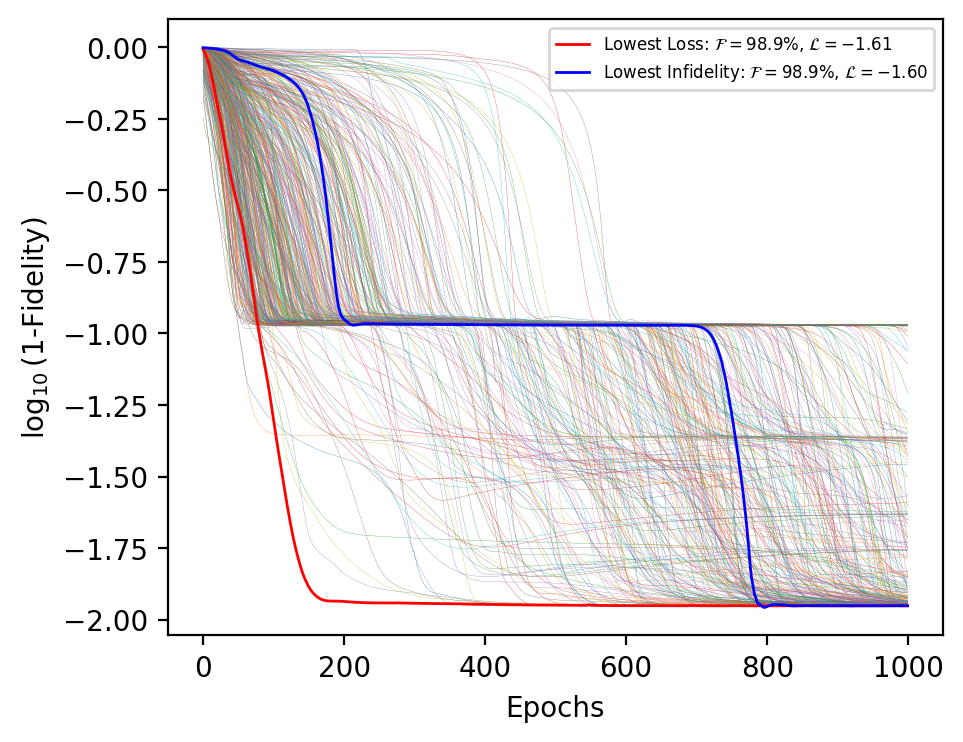

In [24]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c7d3851350>)

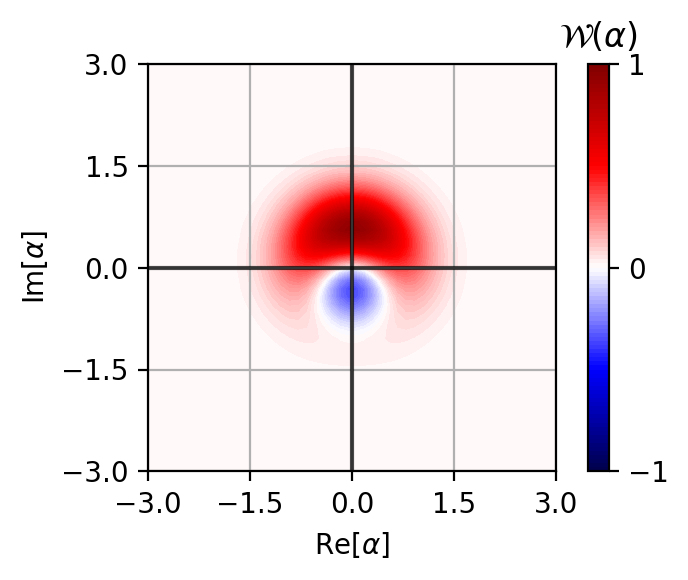

In [25]:
pts = jnp.linspace(-3, 3, 50)
jqt.plot_wigner(target_state_cavity, pts)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c7d38007d0>)

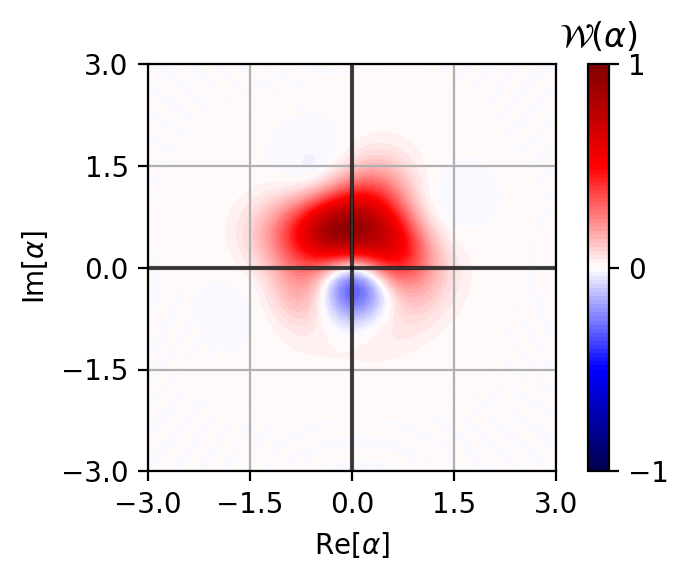

In [26]:
pts = jnp.linspace(-3, 3, 50)
prepared_state = run_circuit(params_history[best_metric_epoch_indx, best_metric_batch_indx], settings["N"])
jqt.plot_wigner(prepared_state, pts)

In [27]:
# data=np.load(r"./data/20251014_h16m53s23_fock_state_prep_plusx.npz", allow_pickle=True)
# optimal_instructions = data["best_params"]

# best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

# prepared_state = run_circuit(best_params, 100)

Best parameters: 
 [[ 0.90124   0.003055  0.085249  0.776089]
 [ 0.186935  0.77733   0.251285  0.454009]
 [ 0.997723 -0.344338 -0.46016   0.26268 ]
 [ 0.369186  0.905709 -0.297822 -0.536646]]


Text(0.5, 1.02, '20251015_h09m10s40_fock_state_prep.npz, $\\vert+y\\rangle,$ $\\mathcal{F}=0.989$, $N_B=4$, $\\beta=0.5$')

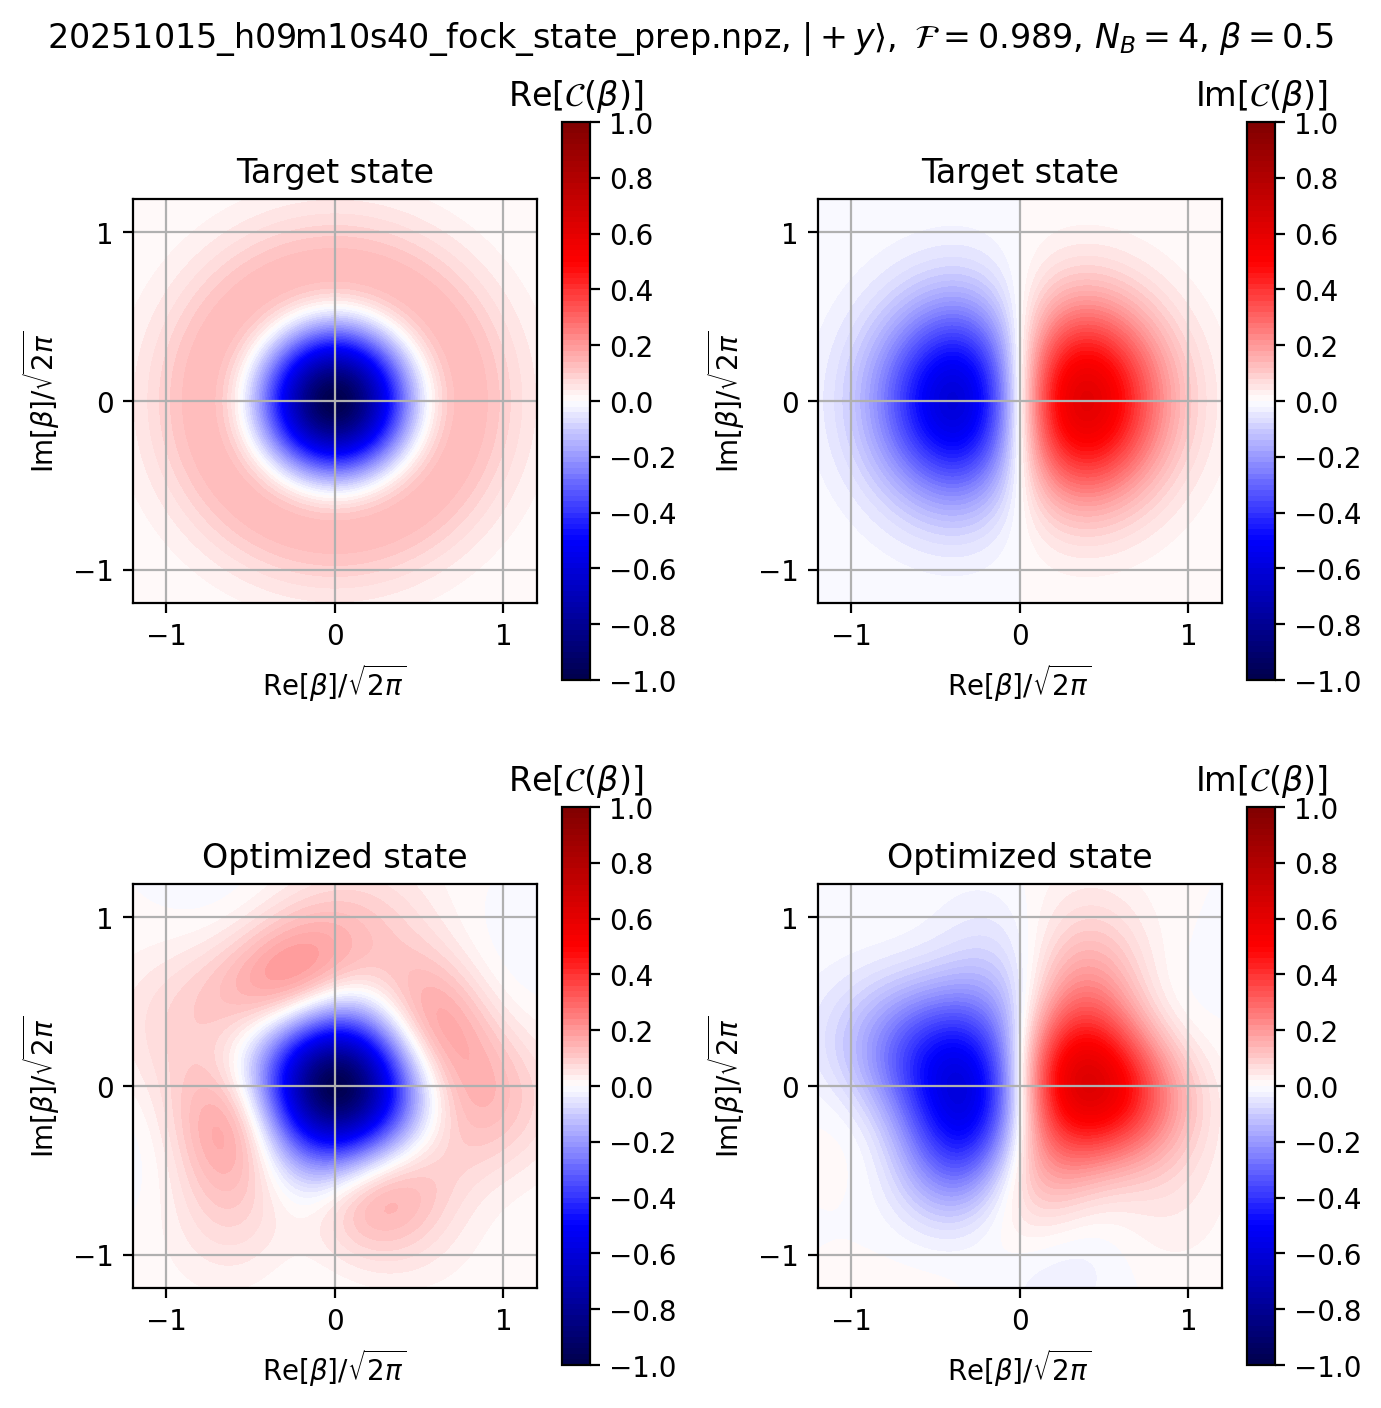

In [28]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(7,7))
axs = axs.flatten()
print("Best parameters: \n", best_params)
N_large = 75
if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()

target_state_larger = jqt.basis(2,0) ^ target_state_cavity

prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)



betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")



fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['state']}\\rangle,$ $\\mathcal{{F}}={fid:.3f}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)

In [29]:
settings = {
    "measure": None,
    "blocks": 4,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 75,
    "state": {
        "mode": "fock",
        "state": "-y"
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 35,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": True
}

if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()


settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

# 4 - Batch Gradient Descent

In [30]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [31]:
# Functions


# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

203 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
57.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
187 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
52.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [32]:
history = optimize(random_initial_params, settings)

Running for 1,000 iterations: 100%|█████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


In [33]:
fids_history = history["fids"]
metric_batch_history = history["metric_batch"]
params_history = history["params"]
metric_history = history["metric"]

In [34]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [35]:
best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

In [36]:
if settings["minimize_metric"] == False:
    best_params = params_history[best_fids_epoch_indx, best_fids_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]
np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

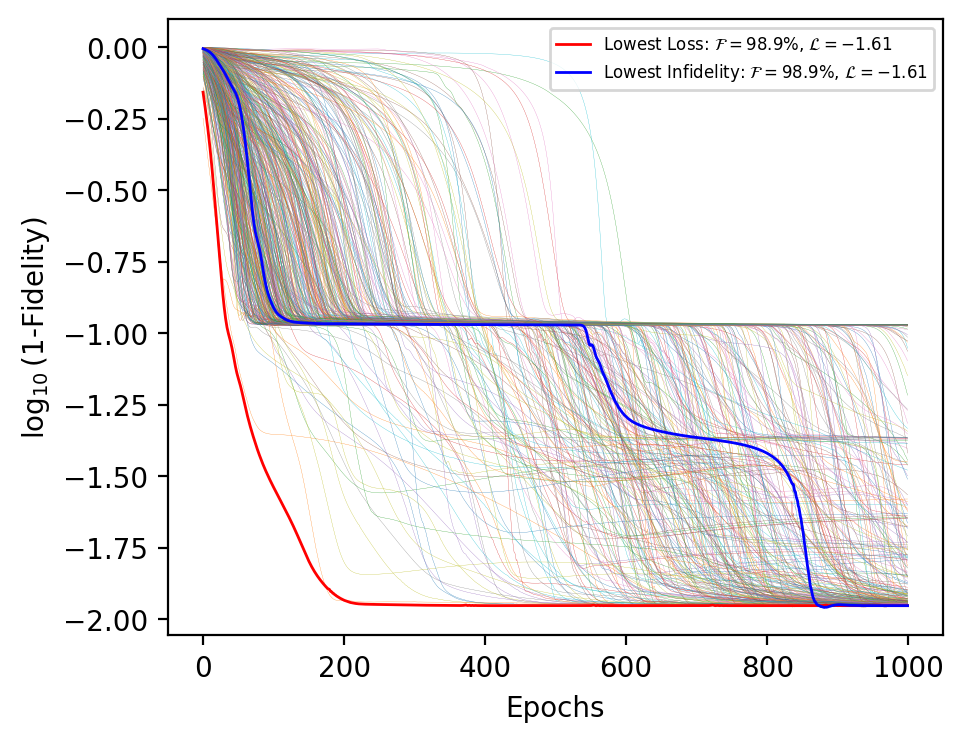

In [37]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c7d3699750>)

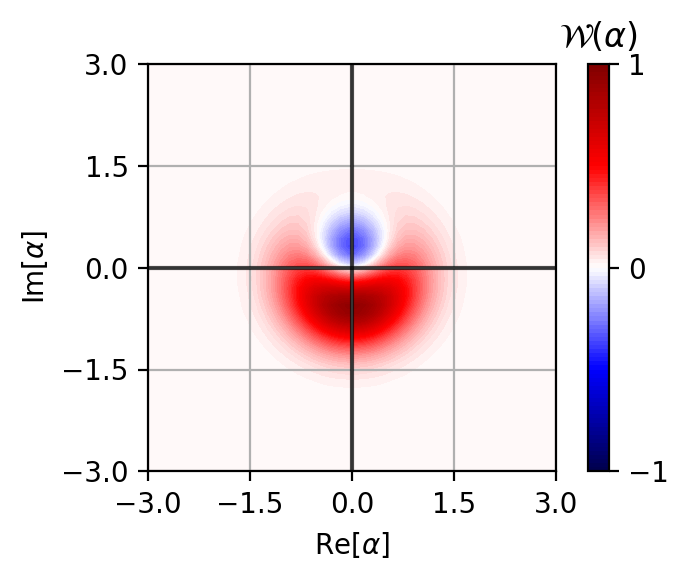

In [38]:
pts = jnp.linspace(-3, 3, 50)
jqt.plot_wigner(target_state_cavity, pts)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c89d7090d0>)

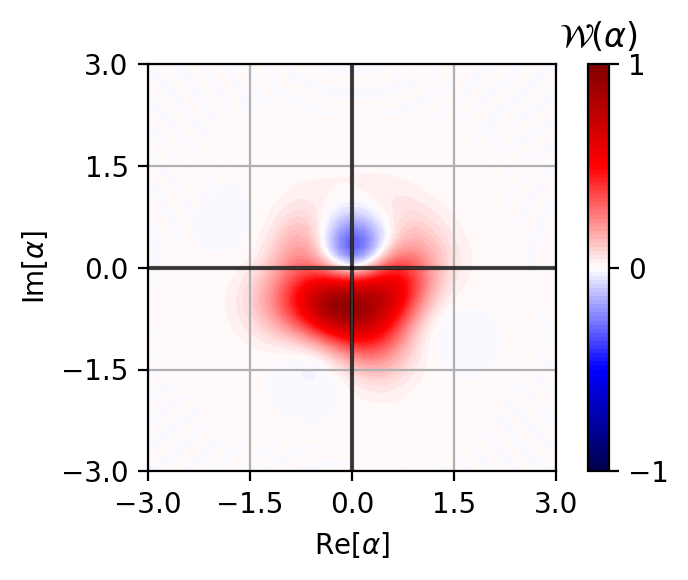

In [39]:
pts = jnp.linspace(-3, 3, 50)
prepared_state = run_circuit(params_history[best_metric_epoch_indx, best_metric_batch_indx], settings["N"])
jqt.plot_wigner(prepared_state, pts)

In [40]:
# data=np.load(r"./data/20251014_h16m53s23_fock_state_prep_plusx.npz", allow_pickle=True)
# optimal_instructions = data["best_params"]

# best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

# prepared_state = run_circuit(best_params, 100)

Best parameters: 
 [[ 0.024678  0.287027  0.748851  0.843146]
 [ 0.301705  0.883584  0.528624  0.795739]
 [-0.997138 -0.345793  0.459558  0.263591]
 [ 0.370821 -0.905071 -0.299018  0.536265]]


Text(0.5, 1.02, '20251015_h09m15s01_fock_state_prep.npz, $\\vert-y\\rangle,$ $\\mathcal{F}=0.989$, $N_B=4$, $\\beta=0.5$')

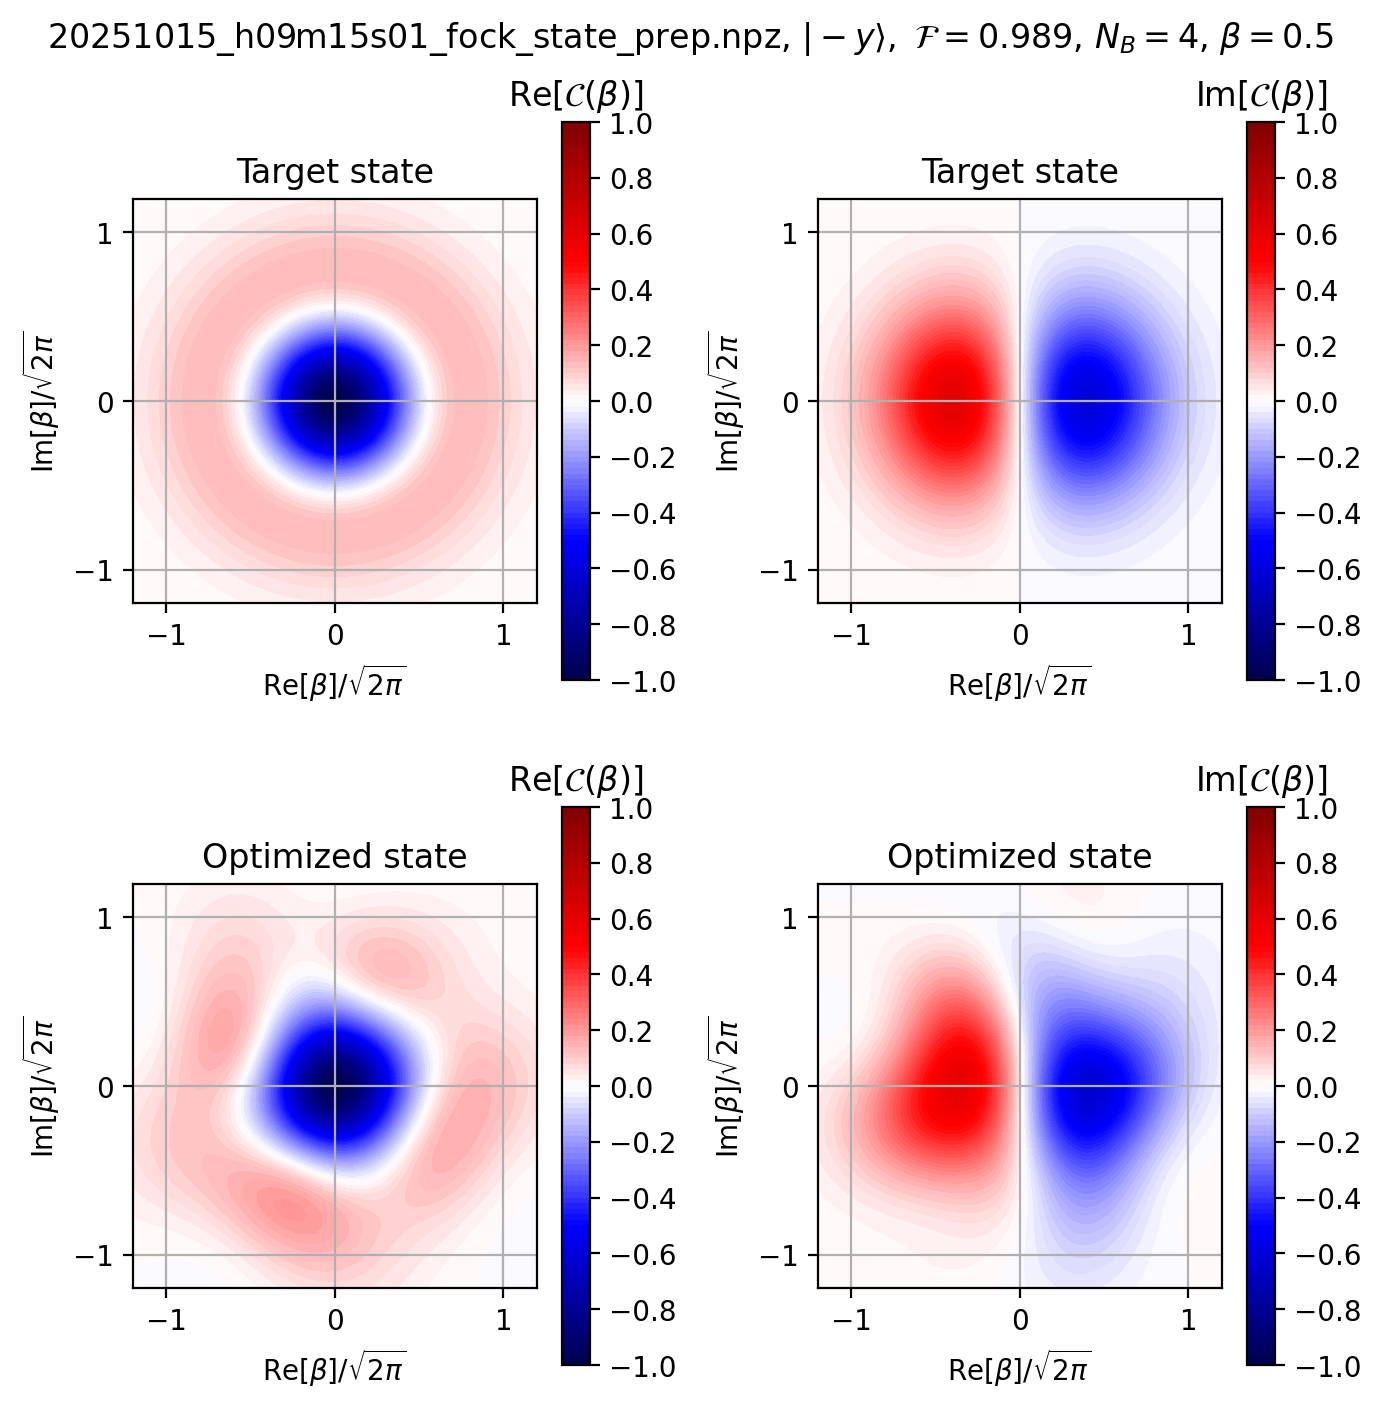

In [41]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(7,7))
axs = axs.flatten()
print("Best parameters: \n", best_params)
N_large = 75
if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()

target_state_larger = jqt.basis(2,0) ^ target_state_cavity

prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)



betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")



fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['state']}\\rangle,$ $\\mathcal{{F}}={fid:.3f}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)

In [42]:
settings = {
    "measure": None,
    "blocks": 4,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 75,
    "state": {
        "mode": "fock",
        "state": "+z"
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 35,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": True
}

if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()


settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

# 4 - Batch Gradient Descent

In [43]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [44]:
# Functions


# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

208 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
57.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
187 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
52.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [45]:
history = optimize(random_initial_params, settings)

Running for 1,000 iterations: 100%|█████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


In [46]:
fids_history = history["fids"]
metric_batch_history = history["metric_batch"]
params_history = history["params"]
metric_history = history["metric"]

In [47]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [48]:
best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

In [49]:
if settings["minimize_metric"] == False:
    best_params = params_history[best_fids_epoch_indx, best_fids_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]
np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

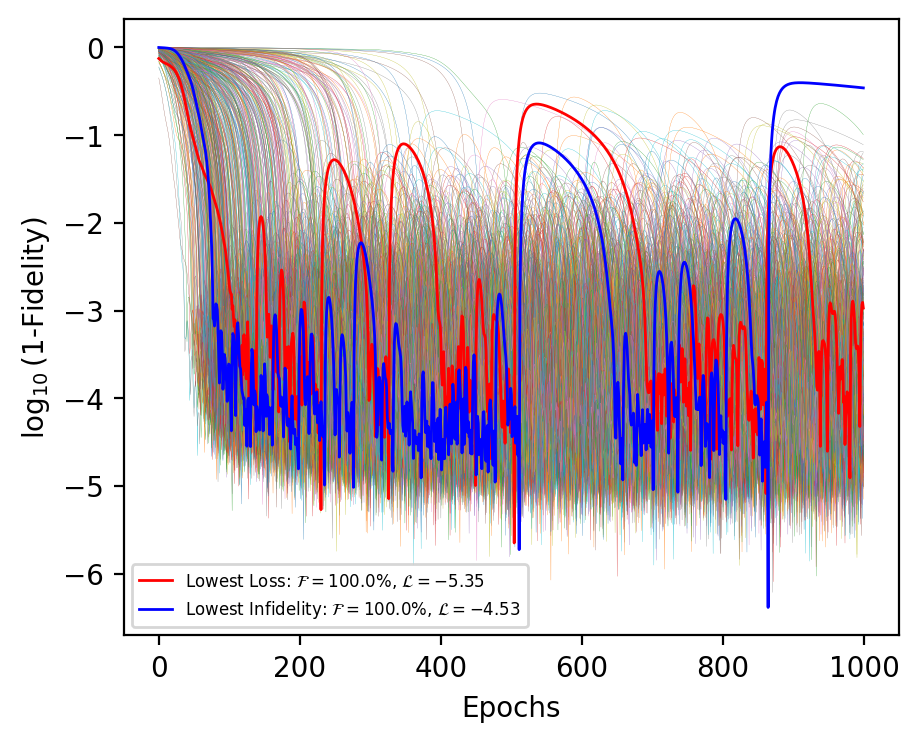

In [50]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c7d29c5ed0>)

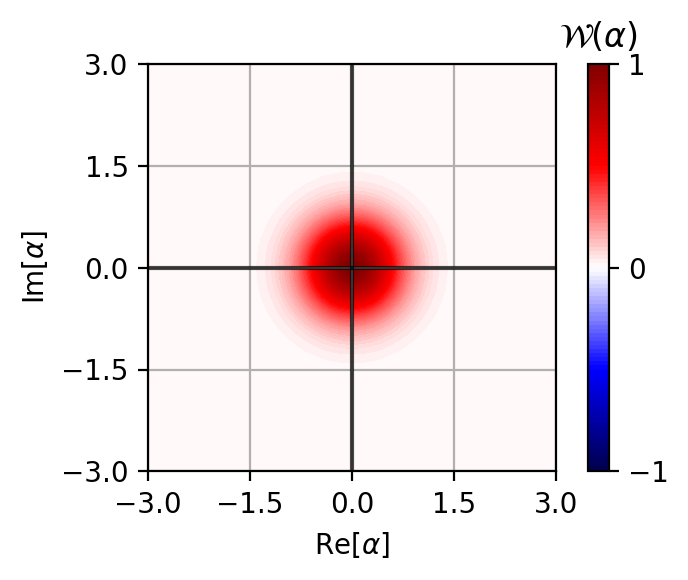

In [51]:
pts = jnp.linspace(-3, 3, 50)
jqt.plot_wigner(target_state_cavity, pts)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c7d3dc87d0>)

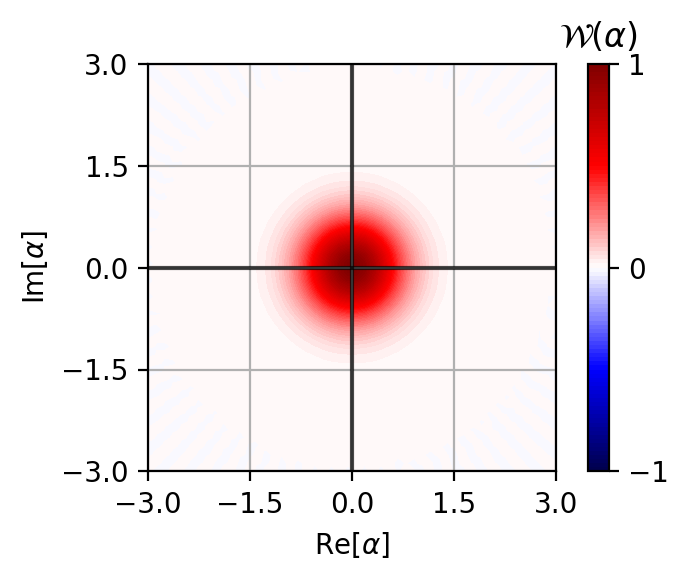

In [52]:
pts = jnp.linspace(-3, 3, 50)
prepared_state = run_circuit(params_history[best_metric_epoch_indx, best_metric_batch_indx], settings["N"])
jqt.plot_wigner(prepared_state, pts)

In [53]:
# data=np.load(r"./data/20251014_h16m53s23_fock_state_prep_plusx.npz", allow_pickle=True)
# optimal_instructions = data["best_params"]

# best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

# prepared_state = run_circuit(best_params, 100)

Best parameters: 
 [[ 2.285400e-02  5.000520e-01  5.001090e-01  4.672000e-01]
 [ 6.273450e-01  4.160000e-04  4.998500e-01  3.743720e-01]
 [ 3.084260e-01 -1.310750e-01  1.775850e-01  1.200000e-05]
 [ 1.216604e+00 -4.382880e-01  7.781350e-01  1.213000e-03]]


Text(0.5, 1.02, '20251015_h09m19s21_fock_state_prep.npz, $\\vert+z\\rangle,$ $\\mathcal{F}=1.000$, $N_B=4$, $\\beta=0.5$')

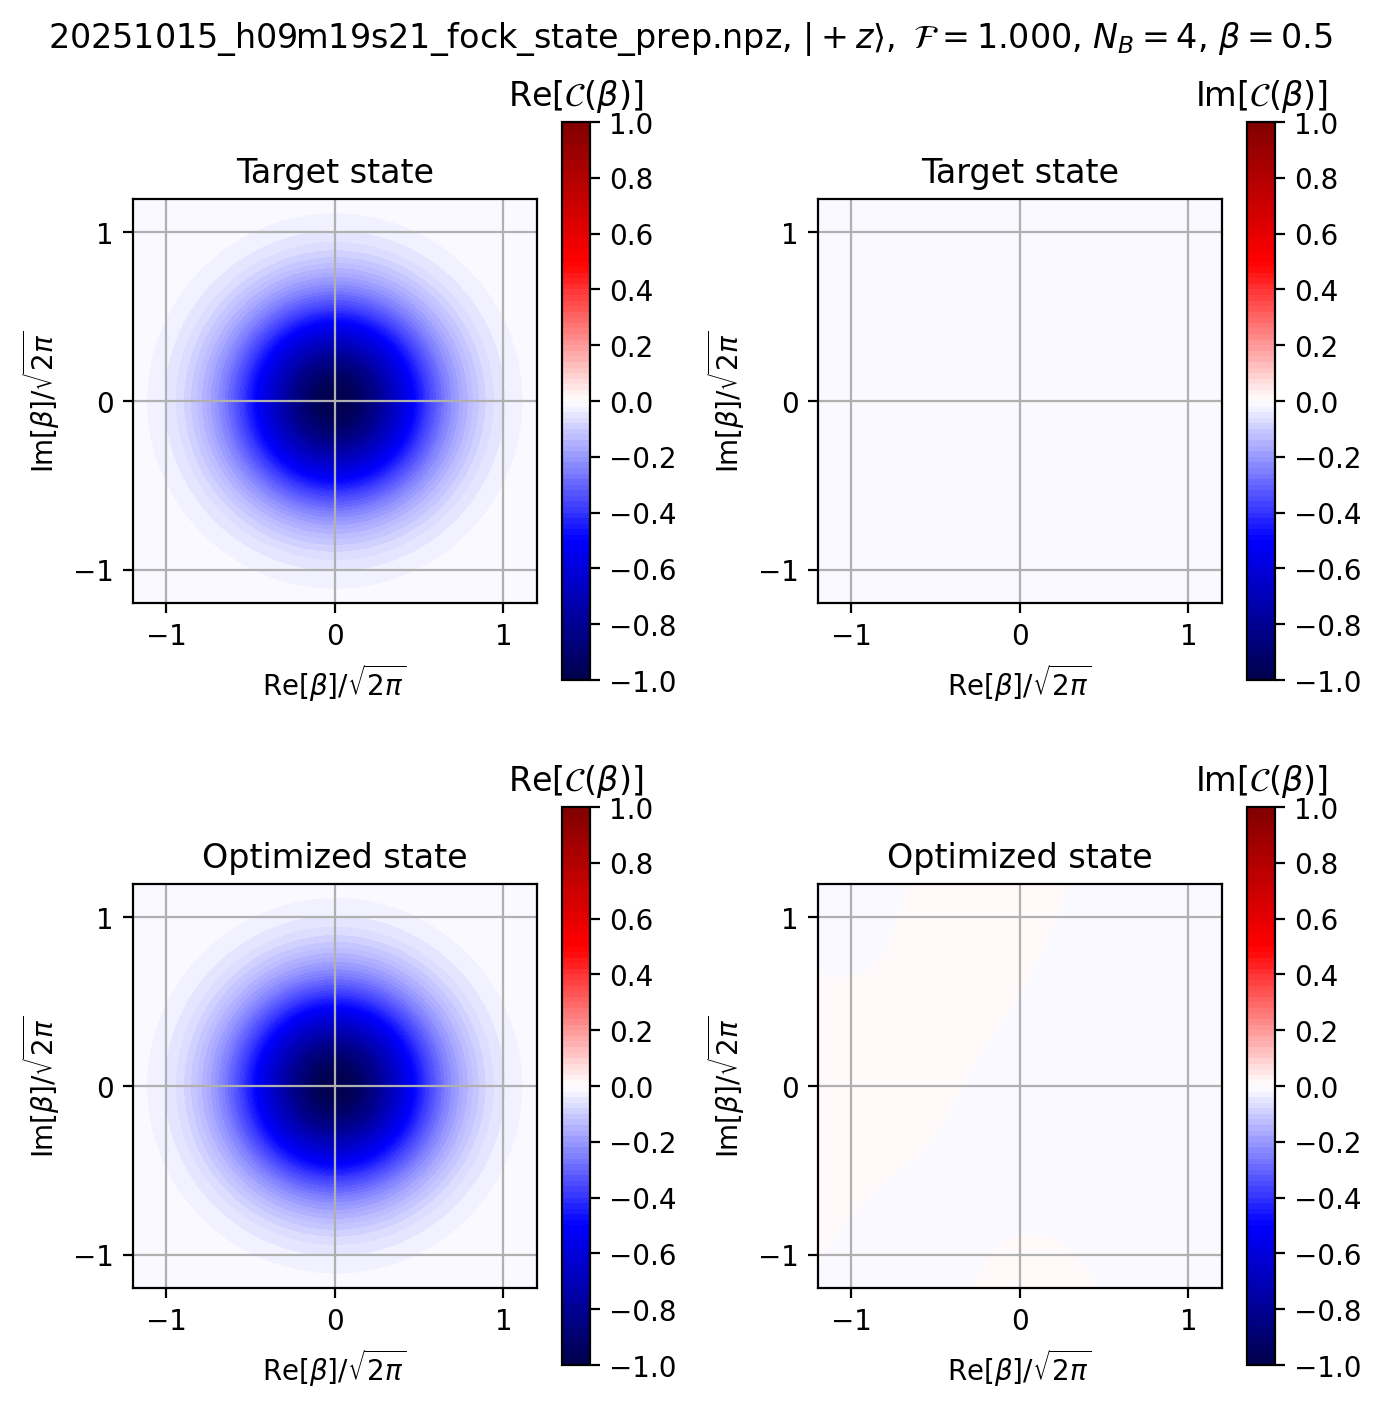

In [54]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(7,7))
axs = axs.flatten()
print("Best parameters: \n", best_params)
N_large = 75
if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()

target_state_larger = jqt.basis(2,0) ^ target_state_cavity

prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)



betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")



fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['state']}\\rangle,$ $\\mathcal{{F}}={fid:.3f}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)

In [55]:
settings = {
    "measure": None,
    "blocks": 4,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 75,
    "state": {
        "mode": "fock",
        "state": "-z"
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 35,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": True
}

if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()


settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

# 4 - Batch Gradient Descent

In [56]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [57]:
# Functions


# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

202 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
56.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
187 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
52.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [58]:
history = optimize(random_initial_params, settings)

Running for 1,000 iterations: 100%|█████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


In [59]:
fids_history = history["fids"]
metric_batch_history = history["metric_batch"]
params_history = history["params"]
metric_history = history["metric"]

In [60]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [61]:
best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

In [62]:
if settings["minimize_metric"] == False:
    best_params = params_history[best_fids_epoch_indx, best_fids_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]
np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

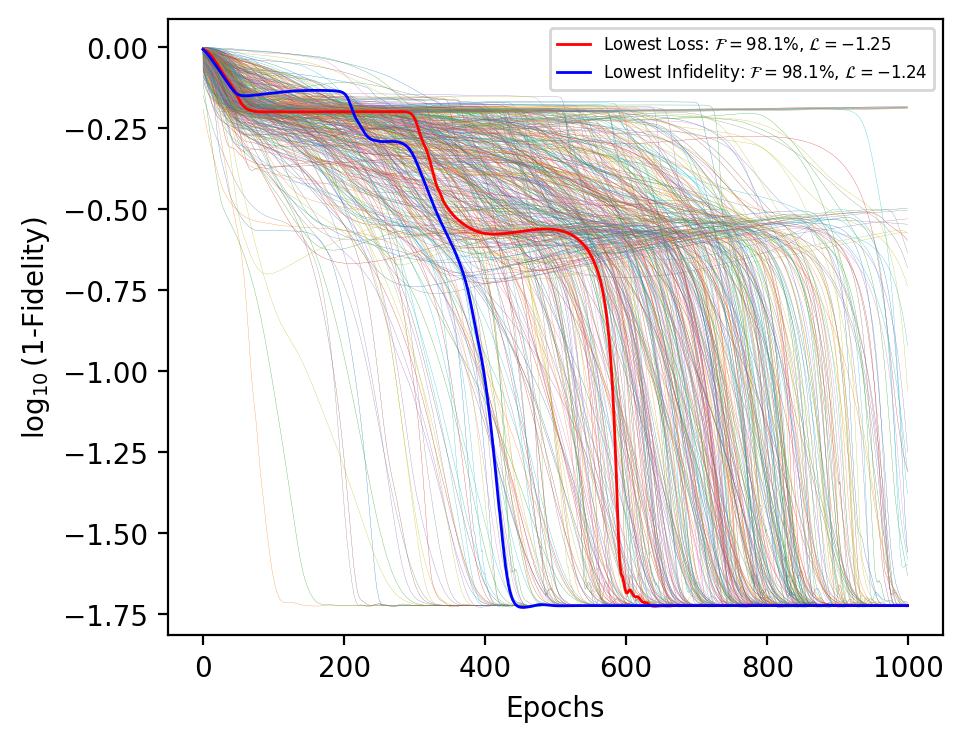

In [63]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c7d20d6750>)

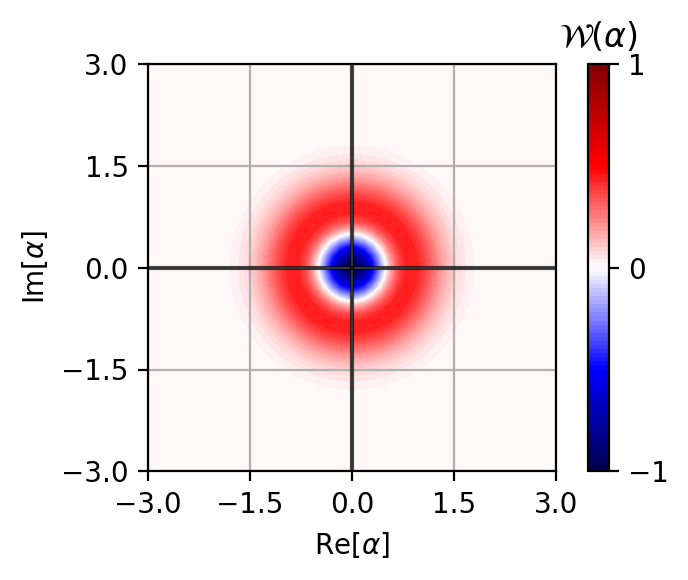

In [64]:
pts = jnp.linspace(-3, 3, 50)
jqt.plot_wigner(target_state_cavity, pts)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14c7d1a91790>)

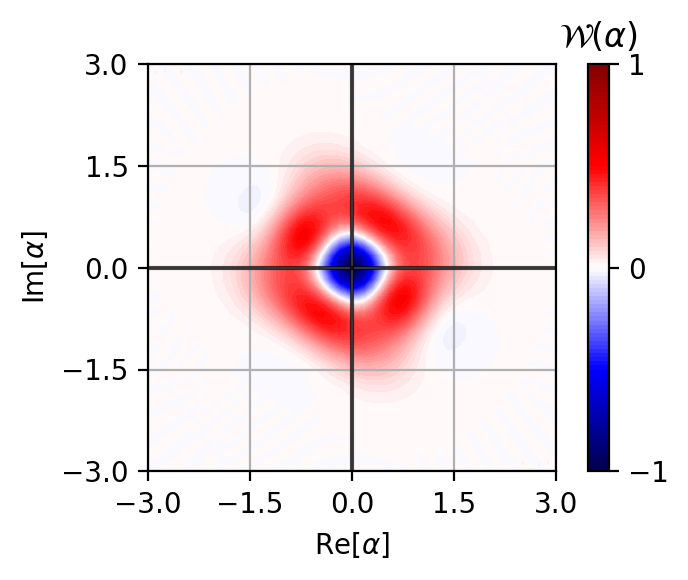

In [65]:
pts = jnp.linspace(-3, 3, 50)
prepared_state = run_circuit(params_history[best_metric_epoch_indx, best_metric_batch_indx], settings["N"])
jqt.plot_wigner(prepared_state, pts)

In [66]:
# data=np.load(r"./data/20251014_h16m53s23_fock_state_prep_plusx.npz", allow_pickle=True)
# optimal_instructions = data["best_params"]

# best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

# prepared_state = run_circuit(best_params, 100)

Best parameters: 
 [[ 0.015549  0.75      0.75      0.988936]
 [ 0.25      0.984451  0.5       0.25    ]
 [ 1.275215  0.5636    0.540122  0.      ]
 [-0.856735  0.838896 -0.362873 -0.      ]]


Text(0.5, 1.02, '20251015_h09m23s45_fock_state_prep.npz, $\\vert-z\\rangle,$ $\\mathcal{F}=0.981$, $N_B=4$, $\\beta=0.5$')

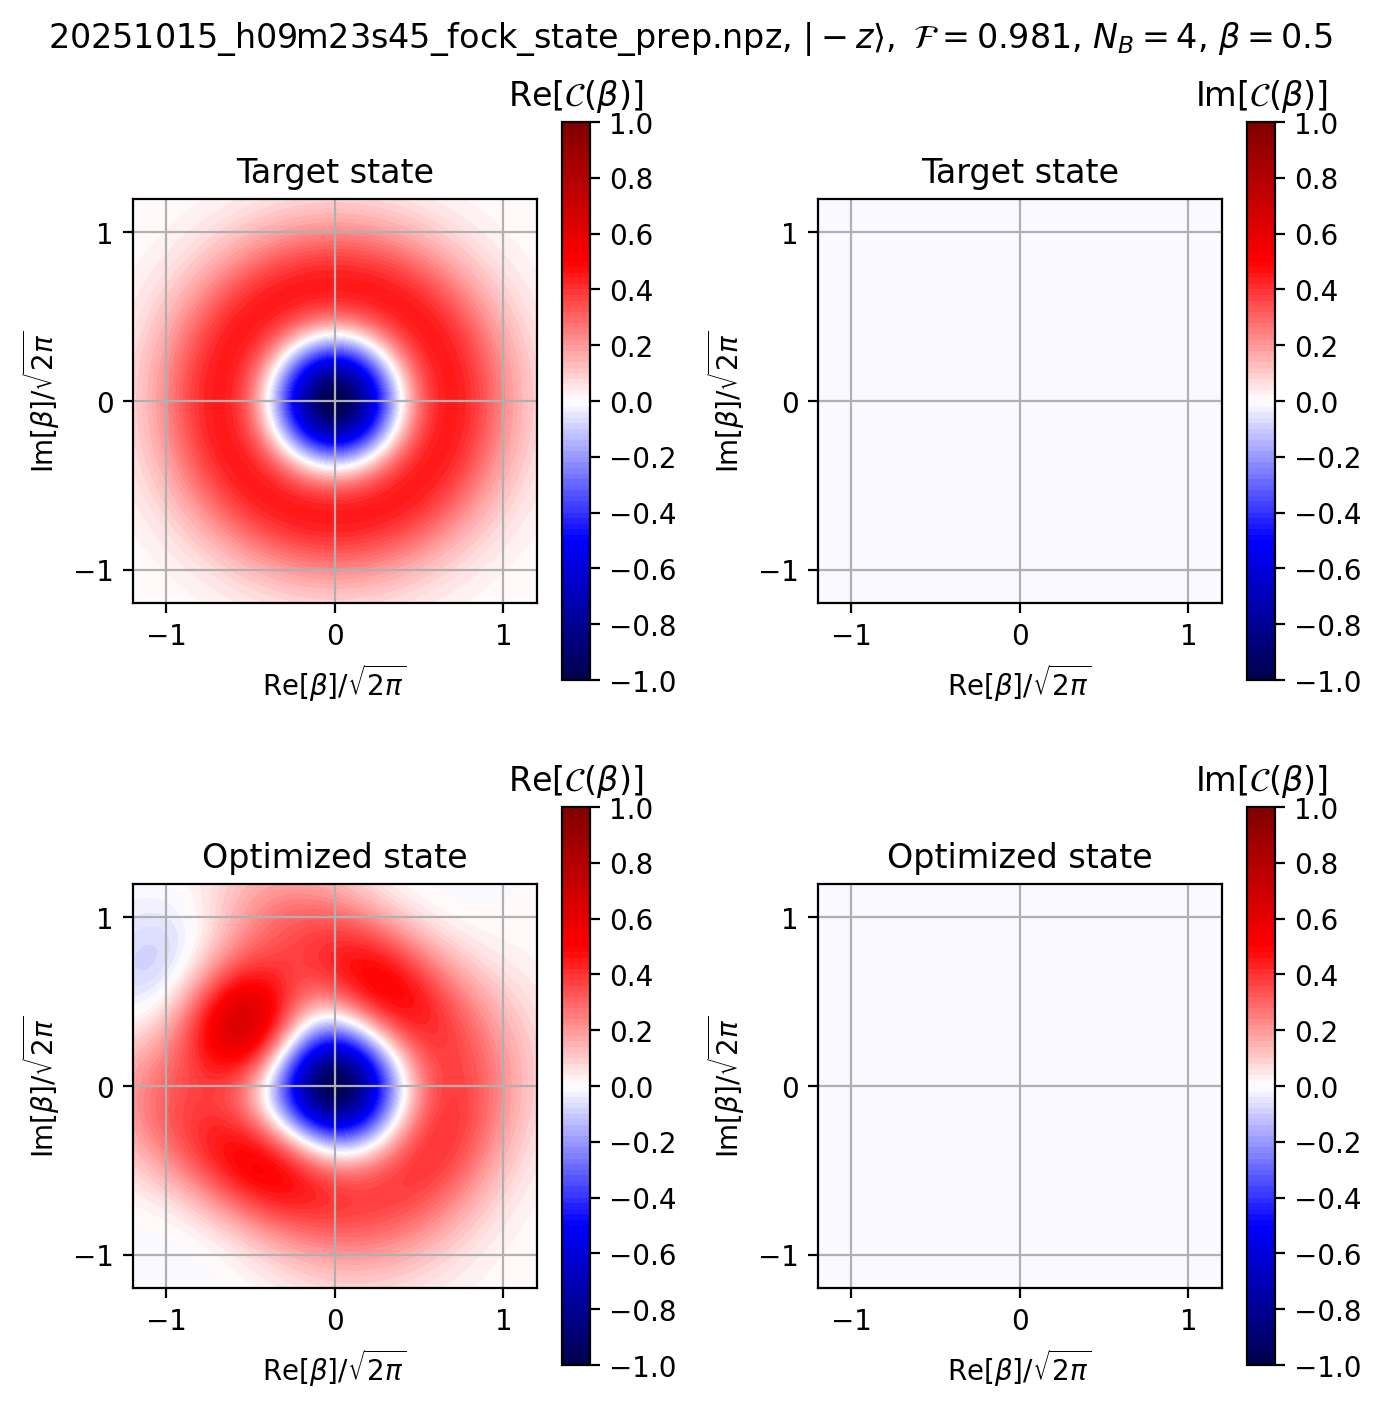

In [67]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(7,7))
axs = axs.flatten()
print("Best parameters: \n", best_params)
N_large = 75
if settings["state"]["mode"]=="fock":
    if settings["state"]["state"]=="+z":
        target_state_cavity = jqt.basis(settings["N"], 0)
    if settings["state"]["state"]=="-z":
        target_state_cavity = jqt.basis(settings["N"], 1)
    if settings["state"]["state"]=="+x":
        target_state_cavity = (jqt.basis(settings["N"], 0) + jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-x":
        target_state_cavity = (jqt.basis(settings["N"], 0) - jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="+y":
        target_state_cavity = (jqt.basis(settings["N"], 0) + 1.j*jqt.basis(settings["N"], 1)).unit()
    if settings["state"]["state"]=="-y":
        target_state_cavity = (jqt.basis(settings["N"], 0) - 1.j*jqt.basis(settings["N"], 1)).unit()

target_state_larger = jqt.basis(2,0) ^ target_state_cavity

prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)



betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")



fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['state']}\\rangle,$ $\\mathcal{{F}}={fid:.3f}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)